In [ ]:
# =============================
# Imports gerais
# =============================
import os
import math
import warnings
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import shap
import xgboost as xgb

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.model_selection import (
    KFold,
    RepeatedKFold
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint

warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
# Funções utilitárias

def safe_log(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))


In [ ]:
# Carregar dataset

print("Loading dataset...")

shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'

try:
    df = gpd.read_file(shp_path)
    print("Dataset loaded")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")


Loading dataset...
Dataset loaded


In [ ]:
# Pré-processamento

columns_removed = ['ros_p_lg1']
df.drop(columns=columns_removed, inplace=True)

# Remover NaN no target
n_before = len(df)
df = df.dropna(subset=['ros_p'])
n_after = len(df)

print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'")

# Converter categóricas
cat_cols = ["fuel_model", "landform", "land_use", "Haines_av"]
for col in cat_cols:
    df[col] = df[col].astype(str).astype("category")

print("Columns disponíveis:")
for col in df.columns:
    print(col)

Removed 0 rows with NaN in 'ros_p'
Columns disponíveis:
ros_p
duration_p
elev_av
aspect_sin
aspect_cos
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wsin10_av
wcos10_av
wv100_k_av
wsin100_av
wcos100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wsi_950_av
wco_950_av
wsi_850_av
wco_850_av
wsi_700_av
wco_700_av
wsi_500_av
wco_500_av
wsi_300_av
wco_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSsin_9_av
wScos_9_av
wSv_7_av
wSsin_7_av
wScos_7_av
wSv_5_av
wSsin_5_av
wScos_5_av
wSv_1_av
wSsin_1_av
wScos_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_a

In [ ]:
# Features e target

train_features = [c for c in df.columns if c not in ('ros_p', 'geometry')]

X = df[train_features]
y_raw = df['ros_p']
y = safe_log(y_raw)

print(f"N amostras: {len(y)}")

N amostras: 851


In [ ]:
# Modelo base + Halving Random Search (ligeiramente menos complexo)

base_model = xgb.XGBRegressor(
    n_jobs=-1,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)

rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=42)

param_dist = {
    'max_depth': [3, 4, 5],                      # árvores ligeiramente mais rasas
    'learning_rate': uniform(0.05, 0.10),
    'subsample': uniform(0.6, 0.2),             # menos amostras por árvore
    'colsample_bytree': uniform(0.5, 0.2),      # menos features por árvore
    'colsample_bylevel': uniform(0.6, 0.2),
    'colsample_bynode': uniform(0.6, 0.2),
    'min_child_weight': randint(25, 50),        # folhas maiores → menos splits pequenos
    'gamma': uniform(0.7, 2.0),                 # splits mais restritos
    'reg_alpha': uniform(0.5, 2.0),
    'reg_lambda': uniform(2.5, 3.5),
    'max_delta_step': randint(0, 5),
}


xgb_search = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,
    resource='n_estimators',
    max_resources=300,
    min_resources=20,
    scoring='r2',
    cv=rkf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(X, y)

best_model = xgb_search.best_estimator_

print("\nBest params:", xgb_search.best_params_)
print(f"Best CV R²: {xgb_search.best_score_:.4f}")


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 20
max_resources_: 300
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 15
n_resources: 20
Fitting 20 folds for each of 15 candidates, totalling 300 fits


----------
iter: 1
n_candidates: 8
n_resources: 40
Fitting 20 folds for each of 8 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 4
n_resources: 80
Fitting 20 folds for each of 4 candidates, totalling 80 fits
----------
iter: 3
n_candidates: 2
n_resources: 160
Fitting 20 folds for each of 2 candidates, totalling 40 fits

Best params: {'colsample_bylevel': 0.7521570097233795, 'colsample_bynode': 0.7122554395138992, 'colsample_bytree': 0.6541934359909122, 'gamma': 1.6875911927287814, 'learning_rate': 0.10227328293819941, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 37, 'reg_alpha': 0.9034384046707924, 'reg_lambda': 5.635172584857318, 'subsample': 0.6950740446364223, 'n_estimators': 160}
Best CV R²: 0.5130


In [ ]:
# Avaliação com Repeated K-Fold

r2_train, r2_test, r2_gap = [], [], []

r2_log, mae_log, rmse_log = [], [], []
mae_lin, rmse_lin = [], []

for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(**best_model.get_params())
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # R² train/test e gap
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_test.append(r2_score(y_test, y_test_pred))
    r2_gap.append(r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred))

    # Log
    r2_log.append(r2_score(y_test, y_test_pred))
    mae_log.append(mean_absolute_error(y_test, y_test_pred))
    rmse_log.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Linear
    mae_lin.append(mean_absolute_error(
        inverse_safe_log(y_test),
        inverse_safe_log(y_test_pred)
    ))
    rmse_lin.append(np.sqrt(mean_squared_error(
        inverse_safe_log(y_test),
        inverse_safe_log(y_test_pred)
    )))

# Resultados
print("=== R² ===")
print(f"Train: {np.mean(r2_train):.4f} ± {np.std(r2_train):.4f}")
print(f"Test:  {np.mean(r2_test):.4f} ± {np.std(r2_test):.4f}")
print(f"Gap:   {np.mean(r2_gap):.4f} ± {np.std(r2_gap):.4f}")

print("\n=== LOG ===")
print(f"R²: {np.mean(r2_log):.4f} ± {np.std(r2_log):.4f} m/h")
print(f"MAE: {np.mean(mae_log):.4f} ± {np.std(mae_log):.4f} m/h")
print(f"RMSE: {np.mean(rmse_log):.4f} ± {np.std(rmse_log):.4f} m/h")

print("\n=== LINEAR ===")
print(f"MAE: {np.mean(mae_lin):.2f} ± {np.std(mae_lin):.2f} m/h")
print(f"RMSE: {np.mean(rmse_lin):.2f} ± {np.std(rmse_lin):.2f} m/h")

=== R² ===
Train: 0.7814 ± 0.0064
Test:  0.5152 ± 0.0464
Gap:   0.2662 ± 0.0500

=== LOG ===
R²: 0.5152 ± 0.0464 m/h
MAE: 0.5690 ± 0.0296 m/h
RMSE: 0.7240 ± 0.0396 m/h

=== LINEAR ===
MAE: 398.50 ± 28.69 m/h
RMSE: 685.07 ± 92.33 m/h


In [ ]:
# Treinar modelo final com todos os dados

final_model = xgb.XGBRegressor(**best_model.get_params())
final_model.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.7521570097233795
,colsample_bynode,0.7122554395138992
,colsample_bytree,0.6541934359909122
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


## Feature Selection

In [ ]:
# SHAP global (importância)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

shap_importance = (
    pd.DataFrame({
        "feature": X.columns,
        "importance": np.abs(shap_values).mean(axis=0)
    })
    .sort_values("importance", ascending=False)
)

shap_importance.head(20)


,feature,importance
0,duration_p,0.243269
24,HDW_av,0.140695
35,Recirc,0.100208
105,f_start,0.086088
7,3_8y_fir_p,0.074359
8,8_ny_fir_p,0.070442
10,f_load_av,0.056616
86,wSv_1_av,0.050031
74,gT_8_7_av,0.042955
33,wsin100_av,0.042282


In [ ]:
# =============================
# Seleção progressiva + métricas + predições CV-safe log
# =============================

top_features = shap_importance['feature'].tolist()[:25]
metrics_dict = {i: {} for i in range(1, len(top_features)+1)}

# Dicionário para guardar predições CV-safe log por n_features
pred_log_dict = {}

for i in range(1, len(top_features) + 1):
    feats = top_features[:i]
    X_sub = X[feats]

    # listas temporárias
    r2_train_tmp, r2_test_tmp = [], []
    mae_log_tmp, rmse_log_tmp = [], []
    mae_lin_tmp, rmse_lin_tmp = [], []

    # Criar array temporário de predições CV para este i
    y_pred_cv_log = np.zeros(len(X))

    for tr, te in rkf.split(X_sub):
        model = xgb.XGBRegressor(**best_model.get_params())
        model.fit(X_sub.iloc[tr], y.iloc[tr])

        y_train_pred = model.predict(X_sub.iloc[tr])
        y_test_pred = model.predict(X_sub.iloc[te])

        # Preenchendo predições CV-safe log
        y_pred_cv_log[te] = y_test_pred

        # R² treino/teste
        r2_train_tmp.append(r2_score(y.iloc[tr], y_train_pred))
        r2_test_tmp.append(r2_score(y.iloc[te], y_test_pred))

        # MAE e RMSE log
        mae_log_tmp.append(mean_absolute_error(y.iloc[te], y_test_pred))
        rmse_log_tmp.append(np.sqrt(mean_squared_error(y.iloc[te], y_test_pred)))

        # MAE e RMSE linear (inverse log) — opcional no loop
        y_te_lin = inverse_safe_log(y.iloc[te])
        y_pred_lin_tmp = inverse_safe_log(y_test_pred)
        mae_lin_tmp.append(mean_absolute_error(y_te_lin, y_pred_lin_tmp))
        rmse_lin_tmp.append(np.sqrt(mean_squared_error(y_te_lin, y_pred_lin_tmp)))

    # Guardar médias no dicionário
    metrics_dict[i] = {
        "r2_train_mean": np.mean(r2_train_tmp),
        "r2_train_std": np.std(r2_train_tmp),
        "r2_test_mean": np.mean(r2_test_tmp),
        "r2_test_std": np.std(r2_test_tmp),
        "r2_gap_mean": np.mean(r2_train_tmp) - np.mean(r2_test_tmp),
        "r2_gap_std": np.std(np.array(r2_train_tmp) - np.array(r2_test_tmp)),
        "mae_log_mean": np.mean(mae_log_tmp),
        "mae_log_std": np.std(mae_log_tmp),
        "rmse_log_mean": np.mean(rmse_log_tmp),
        "rmse_log_std": np.std(rmse_log_tmp),
        "mae_lin_mean": np.mean(mae_lin_tmp),
        "mae_lin_std": np.std(mae_lin_tmp),
        "rmse_lin_mean": np.mean(rmse_lin_tmp),
        "rmse_lin_std": np.std(rmse_lin_tmp)
    }

    # Guardar predições log CV-safe para este n_features
    pred_log_dict[i] = y_pred_cv_log.copy()

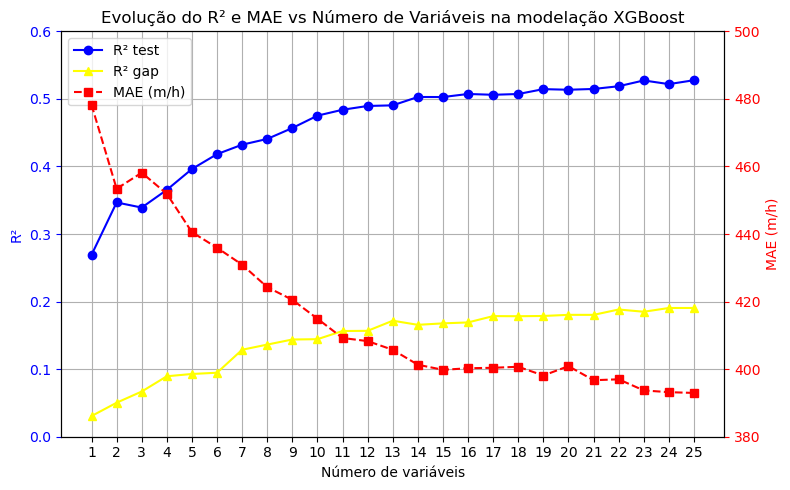

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_vars = range(1, len(top_features) + 1)

# Extrair métricas do dicionário
r2_test_scores_plot = [metrics_dict[i]['r2_test_mean'] for i in num_vars]
r2_gap_scores_plot  = [metrics_dict[i]['r2_gap_mean'] for i in num_vars]
mae_linear_scores_plot = [metrics_dict[i]['mae_lin_mean'] for i in num_vars]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Eixo primário (R²)
ax1.plot(num_vars, r2_test_scores_plot, marker='o', label='R² test', color='blue')
ax1.plot(num_vars, r2_gap_scores_plot, marker='^', color='yellow', label='R² gap')  # linha do gap
ax1.set_xlabel('Número de variáveis')
ax1.set_xticks(list(num_vars))
ax1.set_ylim(0, 0.6)
ax1.set_ylabel('R²', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_title('Evolução do R² e MAE vs Número de Variáveis na modelação XGBoost')
ax1.grid(True, which='both', axis='both')

# Eixo secundário (MAE)
ax2 = ax1.twinx()
ax2.plot(num_vars, mae_linear_scores_plot, marker='s', linestyle='--', color='red', label='MAE (m/h)')

# Definir os dois pontos de mapeamento
r2_point1, mae_point1 = 0.1, 400
r2_point2, mae_point2 = 0.6, 500

# Coeficientes da função linear y2 = a*y1 + b
a = (mae_point2 - mae_point1) / (r2_point2 - r2_point1)
b = mae_point1 - a * r2_point1

# Obter os limites atuais de R² para calcular y2 correspondente
y1_min, y1_max = ax1.get_ylim()
y2_min = a * y1_min + b
y2_max = a * y1_max + b

# Definir limite e ticks do eixo secundário
ax2.set_ylim(y2_min, y2_max)

# Criar ticks de 20 em 20 para y2
mae_ticks = np.arange(380, 501, 20)
ax2.set_yticks(mae_ticks)

ax2.set_ylabel('MAE (m/h)', color='red')
ax2.tick_params(axis='y', colors='red')
ax2.set_xlim(ax1.get_xlim())

# Adicionar legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Modelo final com top N features + save

n_features = 14
selected_features = shap_importance['feature'].tolist()[:n_features]

print(f"Selected features ({n_features}):")
print(selected_features)

X_sel = X[selected_features]

final_model_selected = xgb.XGBRegressor(**best_model.get_params())
final_model_selected.fit(X_sel, y)

leaf_indices = final_model_selected.apply(X_sel)
print(f"Leaf indices shape: {leaf_indices.shape}")  # (n_observações, n_árvores)


model_path = "../../Data/Models/model_xgboost.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_model_selected, f)

print(f"\nModelo salvo em {model_path}")

Selected features (14):
['duration_p', 'HDW_av', 'Recirc', 'f_start', '3_8y_fir_p', '8_ny_fir_p', 'f_load_av', 'wSv_1_av', 'gT_8_7_av', 'wsin100_av', 'wco_500_av', 'rh_2m_av', 'BLH_m_rt', 'DC_12h_av']
Leaf indices shape: (851, 160)

Modelo salvo em ../../Data/Models/model_xgboost.pkl


In [ ]:
m = metrics_dict[n_features]

print(f"=== Desempenho final ({n_features} features) ===")
print(f"R² treino: {m['r2_train_mean']:.4f} ± {m['r2_train_std']:.4f}")
print(f"R² teste : {m['r2_test_mean']:.4f} ± {m['r2_test_std']:.4f}")
print(f"R² gap   : {m['r2_gap_mean']:.4f} ± {m['r2_gap_std']:.4f}\n")

print("=== LOG ===")
print(f"MAE  : {m['mae_log_mean']:.4f} m/h ± {m['mae_log_std']:.4f} m/h")
print(f"RMSE : {m['rmse_log_mean']:.4f} m/h ± {m['rmse_log_std']:.4f} m/h\n")

print("=== LINEAR ===")
print(f"MAE  : {m['mae_lin_mean']:.2f} m/h ± {m['mae_lin_std']:.2f} m/h")
print(f"RMSE : {m['rmse_lin_mean']:.2f} m/h ± {m['rmse_lin_std']:.2f} m/h")

=== Desempenho final (14 features) ===
R² treino: 0.6684 ± 0.0103
R² teste : 0.5028 ± 0.0492
R² gap   : 0.1656 ± 0.0576

=== LOG ===
MAE  : 0.5739 m/h ± 0.0351 m/h
RMSE : 0.7331 m/h ± 0.0434 m/h

=== LINEAR ===
MAE  : 401.31 m/h ± 30.64 m/h
RMSE : 691.30 m/h ± 89.90 m/h


In [ ]:
# =============================
# SHAP + Predições médias + Merge com GeoDataFrame
# =============================

avg_pred_log = pred_log_dict[n_features]           # predição log CV-safe
avg_pred_linear = inverse_safe_log(avg_pred_log)   # predição linear
avg_actual_log = y.values                           # valores reais log
avg_actual_linear = inverse_safe_log(y.values).round(6)     # valores reais linear

# -----------------------------
# Carregar shapefile e selecionar apenas observações do df
# -----------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)
gdf_valid = gdf.loc[df.index].reset_index(drop=True)

# -----------------------------
# Criar DataFrame de resultados
# -----------------------------
shap_results = pd.DataFrame({
    'ros_p_log': avg_actual_log,
    'ros_p_linear': avg_actual_linear,
    'PredROS_log': avg_pred_log,
    'PredROS_linear': avg_pred_linear,
})

# Erros e flags
shap_results['PredDiff'] = shap_results['PredROS_linear'] - shap_results['ros_p_linear']
shap_results['Err_pct'] = (shap_results['PredDiff'] / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > 35

In [ ]:
# -----------------------------
# SHAP values para o modelo final
# -----------------------------
explainer = shap.TreeExplainer(final_model_selected)
shap_values = explainer.shap_values(X_sel)

shap_values_df = pd.DataFrame(
    shap_values,
    columns=selected_features,
    index=X_sel.index
)

# Evitar colisões de nomes
shap_values_df = shap_values_df.add_prefix("shap_")

# -----------------------------
# Merge com GeoDataFrame
# -----------------------------

shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_short.shp'
gdf_final = gpd.read_file(shp_path)

merged_gdf = gpd.GeoDataFrame(
    pd.concat([
        gdf_final.reset_index(drop=True),
        shap_results.reset_index(drop=True),
        shap_values_df.reset_index(drop=True)
    ], axis=1),
    geometry='geometry',
    crs=gdf_final.crs
)


In [ ]:
# -----------------------------
# Export
# -----------------------------
output_base = "../../Data/Models/PT_FireProg_model_SHAP_xgboost"

merged_gdf.to_file(f"{output_base}.shp")
merged_gdf.drop(columns='geometry').to_csv(f"{output_base}.csv", index=False)

print("✓ SHP e CSV exportados com sucesso")

✓ SHP e CSV exportados com sucesso


## PLOTS

In [ ]:
# Extrair métricas do dicionário
metrics = metrics_dict[n_features]

r2_train_cv = metrics["r2_train_mean"]
r2_train_std = metrics["r2_train_std"]
r2_test_cv = metrics["r2_test_mean"]
r2_test_std = metrics["r2_test_std"]
r2_gap_cv = metrics["r2_gap_mean"]
r2_gap_std = metrics["r2_gap_std"]

mae_cv_mean = metrics["mae_log_mean"]
mae_cv_std = metrics["mae_log_std"]
rmse_cv_mean = metrics["rmse_log_mean"]
rmse_cv_std = metrics["rmse_log_std"]

mae_linear_mean = metrics["mae_lin_mean"]
mae_linear_std = metrics["mae_lin_std"]
rmse_linear_mean = metrics["rmse_lin_mean"]
rmse_linear_std = metrics["rmse_lin_std"]

# Predições log CV-safe para n_features
y_pred_all = pred_log_dict[n_features]
y_actual_all = y

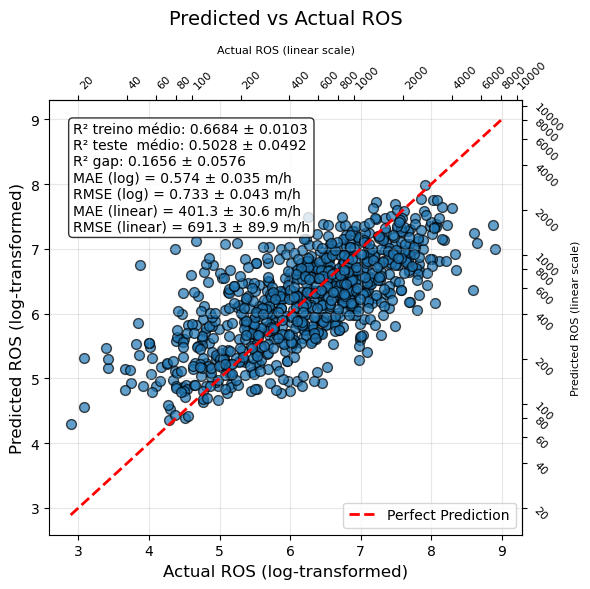

In [ ]:
# =============================
# Scatter Plot com ± std
# =============================
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(y_actual_all, y_pred_all, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_all.min(), y_pred_all.min() - 1)
max_val = max(y_actual_all.max(), y_pred_all.max() + 1)
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_title('Predicted vs Actual ROS', fontsize=14, pad=15)
ax.set_xlabel('Actual ROS (log-transformed) m/h', fontsize=12)
ax.set_ylabel('Predicted ROS (log-transformed) m/h', fontsize=12)

ax.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# =============================
# Eixos secundários (linear scale)
# =============================
def log_to_linear(x):
    return np.exp(x)

def linear_to_log(x):
    # Evita log(0)
    x_safe = np.where(x <= 0, 1e-6, x)
    return np.log(x_safe)

# Eixo superior (x) e direito (y)
ax_top = ax.secondary_xaxis('top', functions=(log_to_linear, linear_to_log))
ax_right = ax.secondary_yaxis('right', functions=(log_to_linear, linear_to_log))

# Ticks escalonados conforme seu exemplo
ticks_linear = list(range(0, 101, 20))        # 0,20,40,60,80,100
ticks_linear += list(range(200, 1001, 200))   # 200,400,...,1000
ticks_linear += list(range(2000, 10001, 2000))# 2000,4000,...,10000

ax_top.set_xticks(ticks_linear)
ax_right.set_yticks(ticks_linear)
plt.setp(ax_right.get_yticklabels(), rotation=315, ha='left', fontsize=8)
plt.setp(ax_top.get_xticklabels(), rotation=45, ha='left', fontsize=8)

ax_top.set_xlabel("Actual ROS (linear scale) m/h", fontsize=8)
ax_right.set_ylabel("Predicted ROS (linear scale) m/h", fontsize=8)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

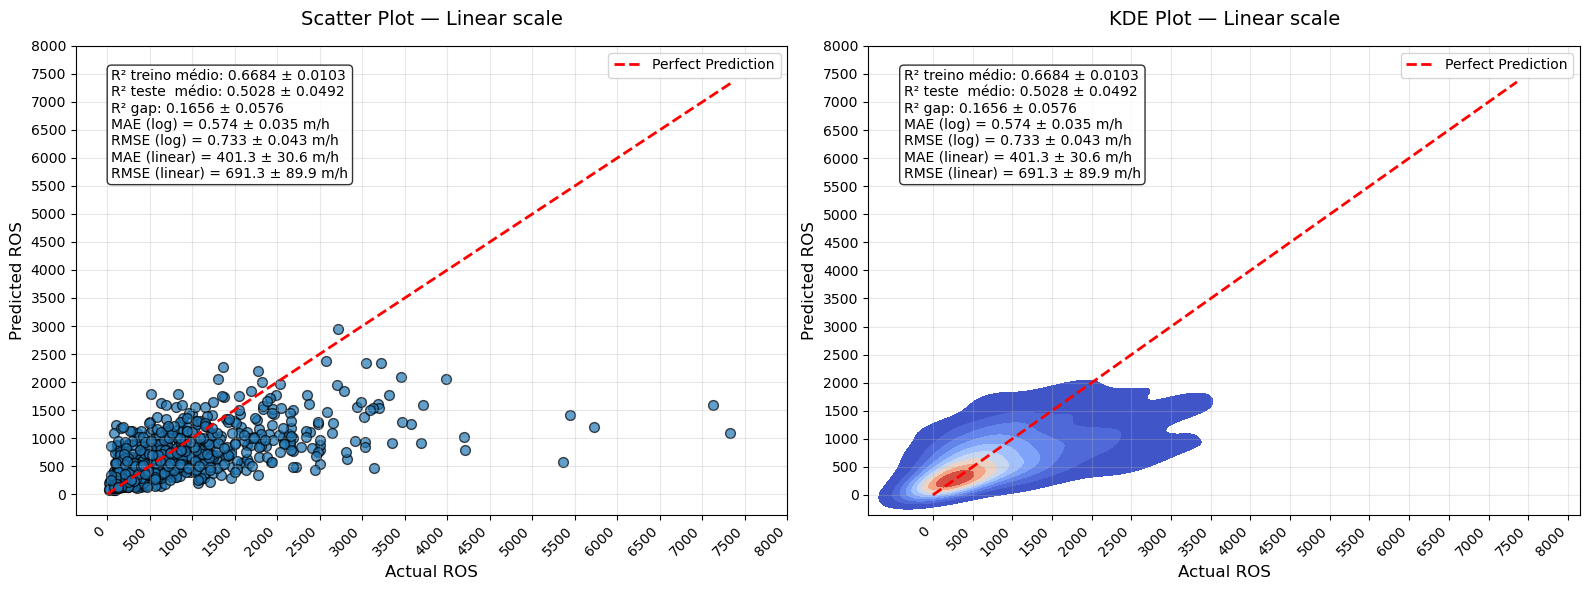

In [ ]:
# =============================
# Scatter + 2D KDE com estilo parecido + caixa de texto
# =============================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# -----------------------------
# Scatter plot (ax1)
# -----------------------------
sc1 = ax1.scatter(
    avg_actual_linear, avg_pred_linear,
    alpha=0.7, edgecolor='k', s=50
)

max_val = max(avg_actual_linear.max(), avg_pred_linear.max()) * 1.005
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_title("Scatter Plot — Linear scale", fontsize=14, pad=15)
ax1.set_xlabel("Actual ROS (linear scale) m/h", fontsize=12)
ax1.set_ylabel("Predicted ROS (linear scale) m/h", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# -----------------------------
# Caixa de texto (ax1)
# -----------------------------
ax1.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h',
    transform=ax1.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# 2D KDE plot (ax2)
# -----------------------------
sns.kdeplot(
    x=avg_actual_linear,
    y=avg_pred_linear,
    fill=True,
    cmap="coolwarm",
    thresh=0.04,
    ax=ax2
)
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title("KDE Plot — Linear scale", fontsize=14, pad=15)
ax2.set_xlabel("Actual ROS (linear scale) m/h", fontsize=12)
ax2.set_ylabel("Predicted ROS (linear scale) m/h", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# -----------------------------
# Caixa de texto (ax2)
# -----------------------------
ax2.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h',
    transform=ax2.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Ticks escalonados e layout
# -----------------------------
ticks = list(range(0, 8001, 500))
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=10)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


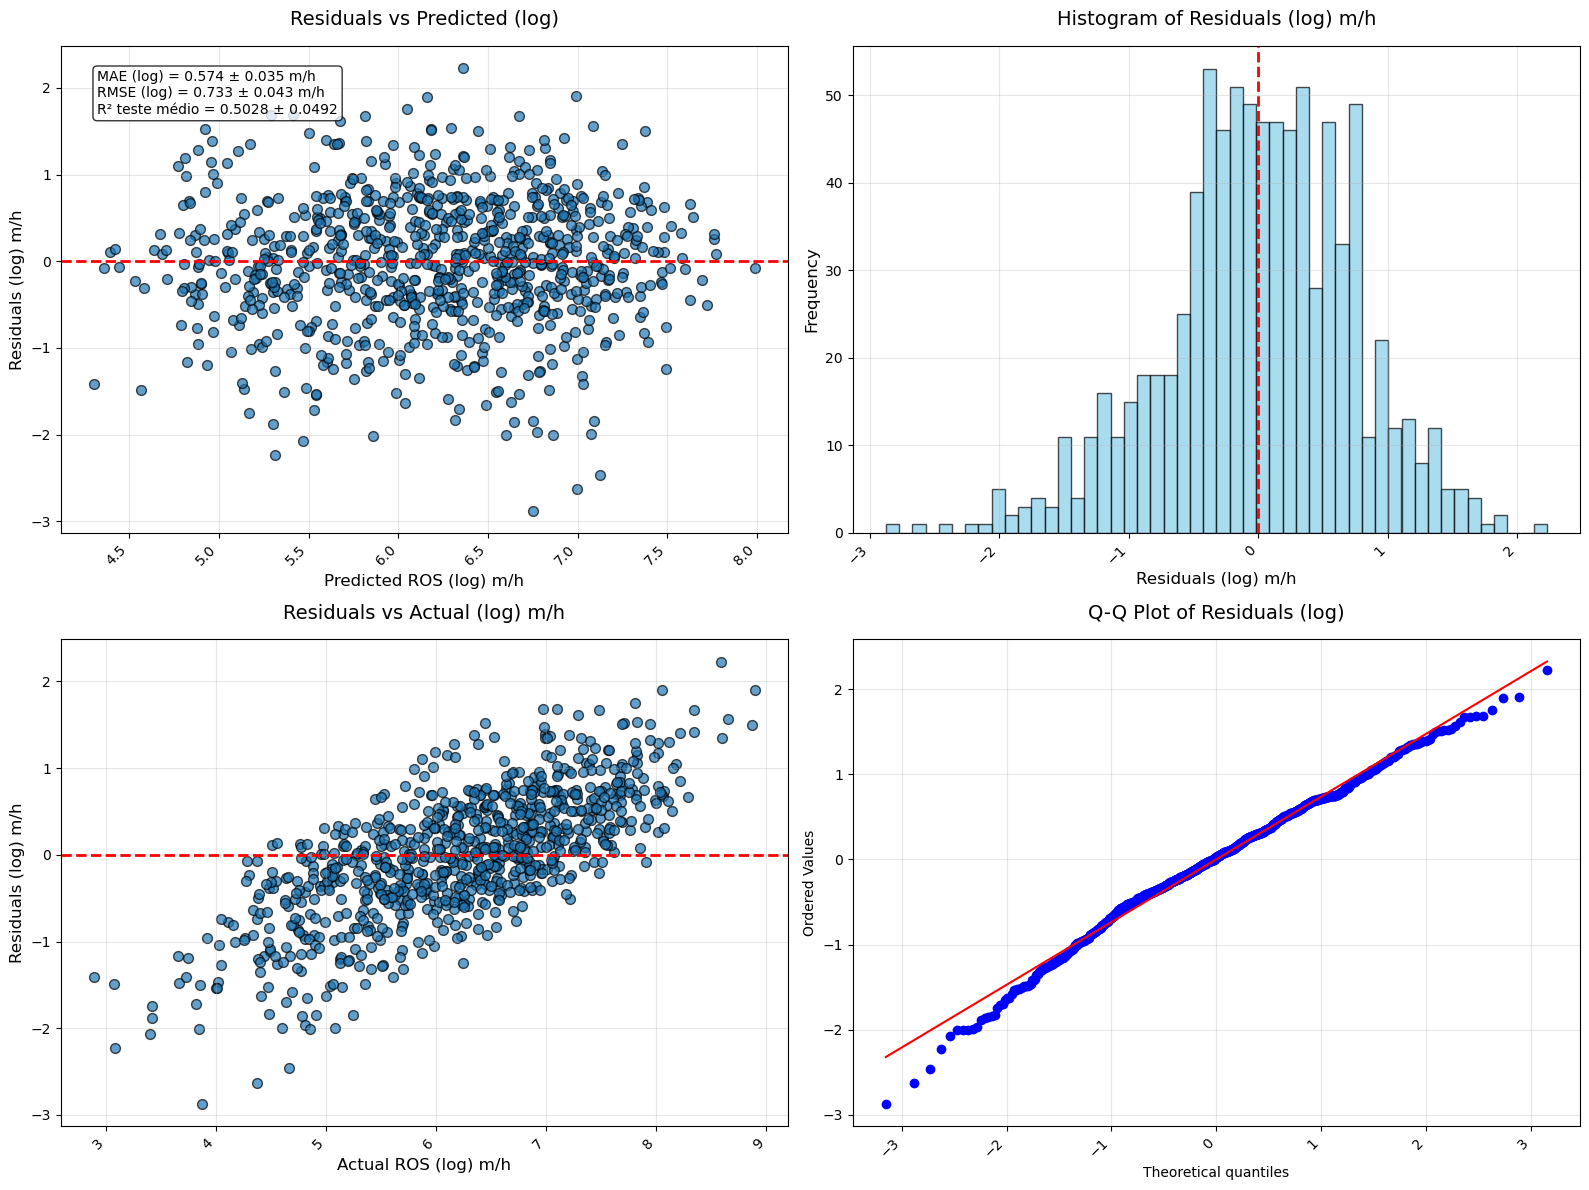

In [ ]:
residuals_log = avg_actual_log - avg_pred_log

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (log)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_log, residuals_log, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (log)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (log) m/h", fontsize=12)
ax.set_ylabel("Residuals (log) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n"
    f"RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_log, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (log) m/h", fontsize=14, pad=15)
ax.set_xlabel("Residuals (log) m/h", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (log)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_log, residuals_log, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (log) m/h", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (log) m/h", fontsize=12)
ax.set_ylabel("Residuals (log) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_log, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (log)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


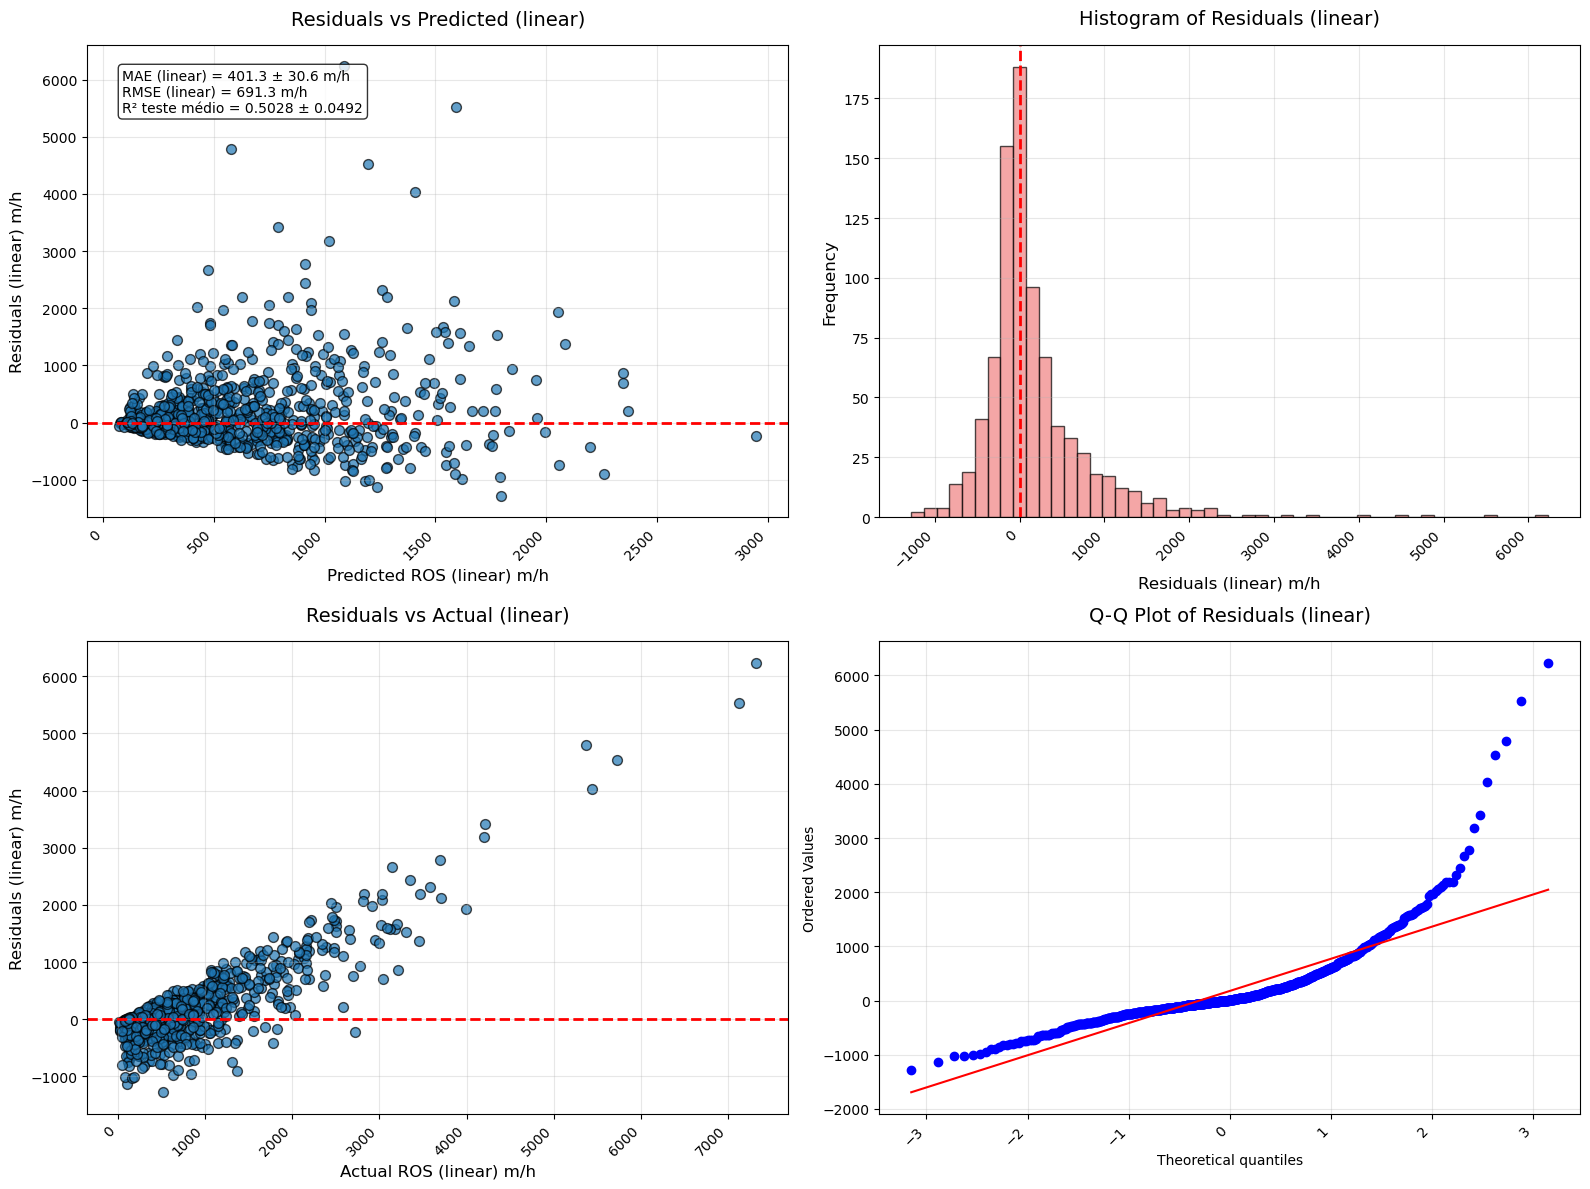

In [ ]:
residuals_linear = avg_actual_linear - avg_pred_linear

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (linear)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (linear)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (linear) m/h", fontsize=12)
ax.set_ylabel("Residuals (linear) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n"
    f"RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_linear, bins=50, color='lightcoral', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (linear)", fontsize=14, pad=15)
ax.set_xlabel("Residuals (linear) m/h", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (linear)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (linear)", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (linear) m/h", fontsize=12)
ax.set_ylabel("Residuals (linear) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_linear, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (linear)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


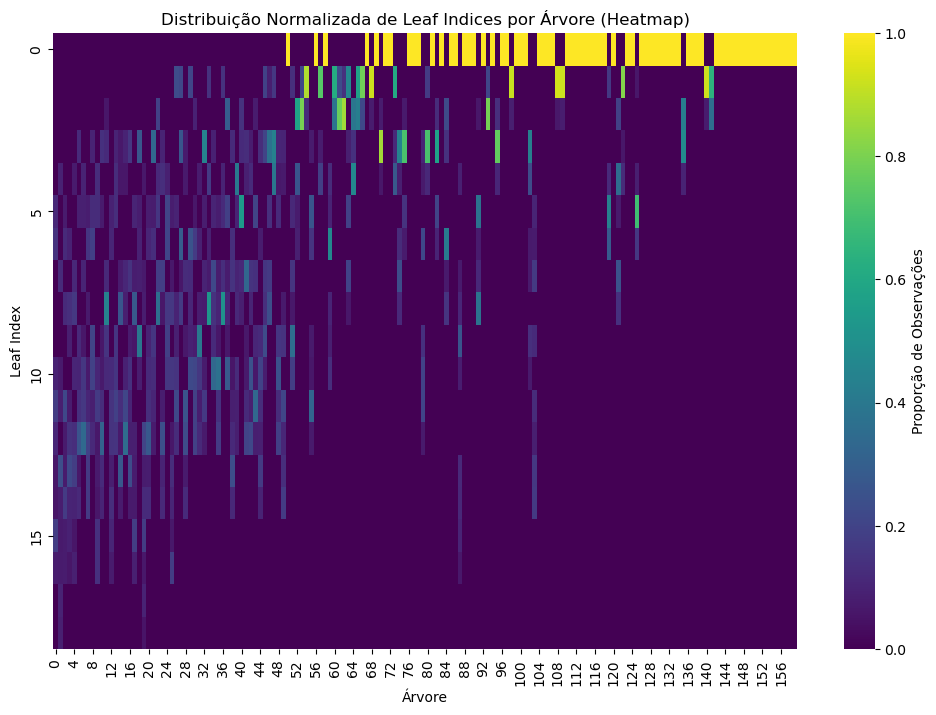

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# leaf_indices: (n_obs, n_trees)
leaf_int = leaf_indices.astype(int)
n_trees = leaf_int.shape[1]

# Descobrir o número máximo de leaf por árvore
max_leaf = leaf_int.max() + 1  # adicionar 1 porque índices começam em 0

# Criar matriz (max_leaf, n_trees) para contar observações
heatmap_matrix = np.zeros((max_leaf, n_trees), dtype=float)

for tree_idx in range(n_trees):
    counts = np.bincount(leaf_int[:, tree_idx], minlength=max_leaf)
    # Normalizar para soma 1
    heatmap_matrix[:, tree_idx] = counts / counts.sum()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_matrix, cmap='viridis', cbar_kws={'label': 'Proporção de Observações'}, 
            yticklabels=5)  # mostrar apenas alguns labels para não poluir

plt.xlabel('Árvore')
plt.ylabel('Leaf Index')
plt.title('Distribuição Normalizada de Leaf Indices por Árvore (Heatmap)')
plt.show()
